In [1]:
import pickle
import shutil
import rasterio
import geopandas
import numpy as np
from os import listdir
from pathlib import Path
import matplotlib.pyplot as plt
from shapely.geometry import shape

#%matplotlib notebook
%matplotlib inline

In [2]:
! pip install rasterio geopandas shapely rasterio tqdm

# Visualize the geometry

In [ ]:
with open("files_metadata.pickle", "rb") as metadata_file:
    products_metadata = pickle.load(metadata_file)        

In [ ]:
_gd = {'productId':[], 'geometry':[]}
for p in products_metadata[0:1]:
    _gd['productId'].append(p['productId'])
    _gd['geometry'].append(shape(p['geometry']['geometries'][0]))
    
_gd

In [ ]:
gdf = geopandas.GeoDataFrame(_gd)

gdf.plot(alpha=0.25, edgecolor='red', legend=True, column='productId', 
         legend_kwds={'loc': 'upper left', 'bbox_to_anchor': (1, 1)}, 
         figsize=(24,16));

## Visualize the images 

In [3]:
datapath = Path("/shared_volume/zipped")
datapath_unzipped = Path("/shared_volume/unzipped")
datapath_png = Path("/shared_volume/png")

Loading the files

In [ ]:
zipped_data_files = [datapath.joinpath(f) for f in listdir(datapath) if datapath.joinpath(f).exists() and ".tif.zip" in f]
zipped_data_files[0:5]

In [ ]:
def display_image(zipped_data_file, datapath_unzipped, freemem=False):  
    
    unzipped_datafile = datapath_unzipped.joinpath(zipped_data_file.stem)
    unzipped_datafile_png = datapath_png.joinpath(zipped_data_file.stem).with_suffix(".png")
    
    if not unzipped_datafile.exists():
        print(f"Unzipping {zipped_data_file}..")
        shutil.unpack_archive(zipped_data_file, datapath_unzipped)
        print("")
    else:
        print(f"Unzipped file already exists: {unzipped_datafile}")
        
    with rasterio.open(unzipped_datafile) as tif:
        img = tif.read(1)
        img[img<=tif.nodata] = np.nan

    fig, ax = plt.subplots(figsize=(8,16))
    plt.imshow(img, cmap = 'viridis')
    plt.colorbar()    
    
    if not unzipped_datafile_png.exists():
        fig.savefig(unzipped_datafile_png, dpi=300)
    else:
        print(f"Png file already exists: {unzipped_datafile_png}")
    
    if freemem:
        fig.clear()
        plt.close(fig)


<b>When a cell tells matplotlib to draw an inline figure, when the cell is executed and the image is drawn, some memory is not released..unless calling clear and close..</b>

In [ ]:
display_image(zipped_data_files[0], datapath_unzipped)

In [ ]:
# To save all png 
for zdf in zipped_data_files:
    display_image(zdf, datapath_unzipped, freemem=True)

In [4]:
unzipped_data_files = [datapath_unzipped.joinpath(f) for f in listdir(datapath_unzipped) if datapath_unzipped.joinpath(f).exists()]
unzipped_data_files[0:5]

[PosixPath('/shared_volume/unzipped/F16_042071_1227_XI_57S091W.cal.map.tif'),
 PosixPath('/shared_volume/unzipped/F16_042053_2201_XI_40N335W.cal.map.tif'),
 PosixPath('/shared_volume/unzipped/F16_042087_1712_XN_08S177W.cal.map.tif'),
 PosixPath('/shared_volume/unzipped/F16_042056_1556_XI_24S049W.cal.map.tif'),
 PosixPath('/shared_volume/unzipped/F16_042075_1647_XI_15S209W.cal.map.tif')]

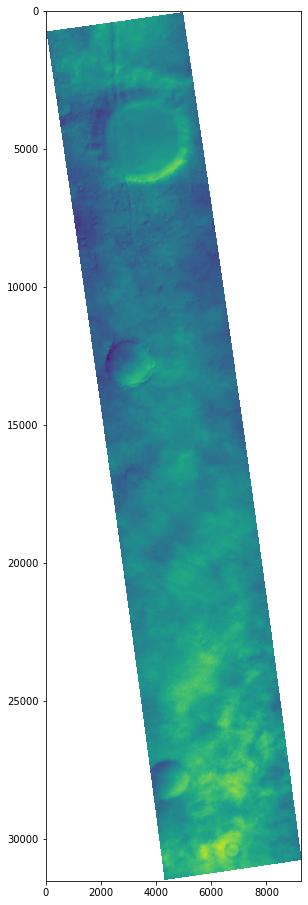

In [5]:
with rasterio.open(unzipped_data_files[0]) as tif:
    imggg = tif.read(1)
    imggg[imggg<=tif.nodata] = np.nan
    fig, ax = plt.subplots(figsize=(8,16))
    plt.imshow(imggg, cmap = 'viridis')

In [6]:
def find_corners_indexes(sub_img_size, nrows, ncols, debug=True):

    rows = range(nrows)
    cols = range(ncols)

    x = rows[0:-1:sub_img_size]
    y = cols[0:-1:sub_img_size]

    corners = []
    for i, _ in enumerate(x[:-1]):
        for j, _ in enumerate(y[:-1]):
            # NO, SO, NE, SE
            corners.append([(x[i], y[j]), (x[i+1], y[j]), (x[i], y[j+1]), (x[i+1], y[j+1])])
    """
    if debug:
        #arr = np.zeros(shape=(nrows,ncols))
        for c in corners:
            #print("c:",c)
            for p in c:
                arr[p[0],p[1]] = 1
        #plt.imshow(arr)
    """
    return corners

In [7]:
#corns = find_corners_indexes(3, 9, 12)
#print(corns)

In [8]:
def is_bad_region(img, c_points):
    for p in c_points:
        if np.isnan(img[p[0], p[1]]) or np.isnan(img[p[0], p[1]]) or np.isnan(img[p[0], p[1]]) or np.isnan(img[p[0], p[1]]):
            return True
    return False

In [9]:
def extract_regions(img, region_size, debug=True):
    print("Image shape: ", img.shape)
    corners = find_corners_indexes(region_size, img.shape[0], img.shape[1], debug=False)
    ok_regions = []
    bad_regions = []
    for c_points in corners:
        if is_bad_region(img, c_points):
            bad_regions.append(c_points)
        else:
            ok_regions.append(c_points)
        
    print(f"Bad regions: {len(bad_regions)}. Ok regions: {len(ok_regions)}")
    
    if debug:
        img_copy = img[:]
        fig, ax = plt.subplots(figsize=(8,16))            
        for i in range(5):
            ind = np.random.choice(range(len(bad_regions)))
            pno,pne,pso,pse = bad_regions[ind]
            print(pno,pne,pso,pse)            
            img_copy[pno[0]:pne[0], pne[1]:pso[1]] = 0       
        for i in range(5):
            ind = np.random.choice(range(len(ok_regions)))
            pno,pne,pso,pse = ok_regions[ind]
            print(pno,pne,pso,pse)
            img_copy[pno[0]:pne[0], pne[1]:pso[1]] = 0.10
        
        plt.imshow(img_copy, cmap="viridis")
        plt.colorbar()

Image shape:  (31530, 9271)
Bad regions: 41. Ok regions: 19
(14336, 0) (16384, 0) (14336, 2048) (16384, 2048)
(18432, 2048) (20480, 2048) (18432, 4096) (20480, 4096)
(4096, 6144) (6144, 6144) (4096, 8192) (6144, 8192)
(2048, 6144) (4096, 6144) (2048, 8192) (4096, 8192)
(22528, 0) (24576, 0) (22528, 2048) (24576, 2048)
(28672, 6144) (30720, 6144) (28672, 8192) (30720, 8192)
(14336, 4096) (16384, 4096) (14336, 6144) (16384, 6144)
(8192, 4096) (10240, 4096) (8192, 6144) (10240, 6144)
(24576, 4096) (26624, 4096) (24576, 6144) (26624, 6144)
(2048, 2048) (4096, 2048) (2048, 4096) (4096, 4096)
CPU times: user 1.49 s, sys: 272 ms, total: 1.77 s
Wall time: 1.76 s


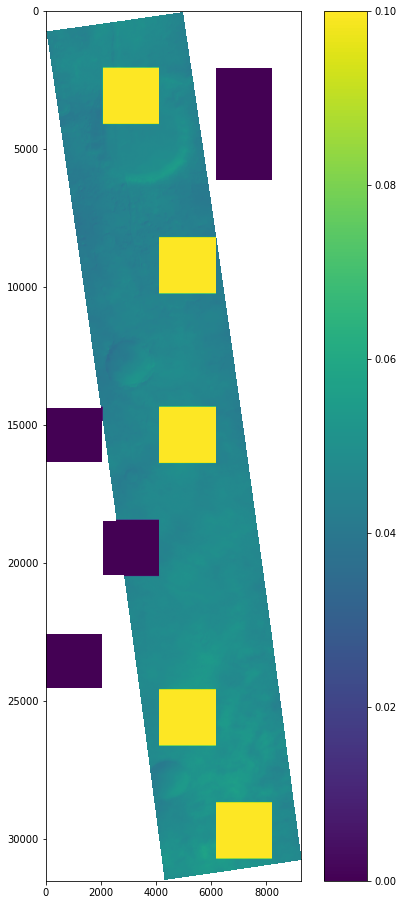

In [10]:
%%time
region_size = 2048
extract_regions(imggg, region_size)

In [11]:
%matplotlib notebook